In [13]:
import time
import matplotlib
import os
import glob
import netCDF4 
import cmocean
import datetime
import numpy as np
from matplotlib import ticker
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cpf
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE

In [14]:
#SGE_TASK_ID = 295
SGE_TASK_ID = 295
#
t0 = time.time()
#
date_min = "20220101"
date_max = "20221231"
#
lead_time = 4
#
ML_models = ["SIC_UNet", "SIC_Res_UNet", "SIC_Attention_UNet", "SIC_Attention_Res_UNet"]
#
paths = {}
paths["training"] = "/lustre/storeB/project/copernicus/cosi/WP3/Data/Training/Land_free_ocean/"
paths["output"] = "/lustre/storeB/users/cyrilp/COSI/Figures/Article/"
for var in ML_models:
    paths[var] = "/lustre/storeB/project/copernicus/cosi/WP3/Data/Predictions/" + var + "/lead_time_" + str(lead_time) + "_days/netCDF/"
#
params_maps = {"map_proj": cartopy.crs.Stereographic(central_latitude = 0.0, central_longitude = 0.0), 
               "LAND_highres": cpf.NaturalEarthFeature("physical", "land", "50m", edgecolor = "face", facecolor = "dimgrey", linewidth = 0.1),
               "map_extent": (-180, 180, 60, 90),
               "levels": [0,1,2,3,5,10,20,30,40,50,60,70,80,90,95,97,98,99,100],
               #"colormap": cmocean.cm.ice,
               "colormap": plt.cm.gist_earth_r,
               "sizefont": 25,
               }
params_maps["norm"] = BoundaryNorm(params_maps["levels"], 256)

In [15]:
def make_list_dates(date_min, date_max):
    current_date = datetime.datetime.strptime(date_min, "%Y%m%d")
    end_date = datetime.datetime.strptime(date_max, "%Y%m%d")
    list_dates = []
    while current_date <= end_date:
        date_str = current_date.strftime("%Y%m%d")
        list_dates.append(date_str)
        current_date = current_date + datetime.timedelta(days = 1)
    return(list_dates)

In [16]:
def load_data(forecast_start_date, paths = paths):
    Datasets = {}
    for var in paths:
        if var != "output":
            if var == "training":
                filename = paths[var] + forecast_start_date[0:4] + "/" + forecast_start_date[4:6] + "/" + "Dataset_" + forecast_start_date + ".nc"
                nc = netCDF4.Dataset(filename, "r")
                Datasets["lat"] = nc.variables["lat"][:,:]
                Datasets["lon"] = nc.variables["lon"][:,:]
                Datasets["AMSR2_SIC_t0"] = nc.variables["SICobs_AMSR2_SIC"][:,:]
                Datasets["TARGET_AMSR2_SIC"] = nc.variables["TARGET_AMSR2_SIC"][lead_time,:,:]
                Datasets["TOPAZ_SIC"] = nc.variables["TOPAZ_SIC"][lead_time,:,:]
                nc.close()
            else:
                filename = paths[var] + "Predictions_" + forecast_start_date + ".nc"
                nc = netCDF4.Dataset(filename, "r")
                Datasets[var + "_Predicted_SIC"] = nc.variables["Predicted_SIC"][:,:] 
                if var == ML_models[0]:
                    Datasets["TOPAZ_bias_corrected"] = nc.variables["TOPAZ_bias_corrected"][:,:]
                nc.close()
    return(Datasets)

In [17]:
def make_maps(Datasets, forecast_start_date, target_date, save = True, lead_time = lead_time, p = params_maps):
    #
    previous_day = (datetime.datetime.strptime(forecast_start_date, "%Y%m%d") - datetime.timedelta(days = 1)).strftime("%Y%m%d")
    forecast_start_date_str = forecast_start_date[6:8] + "/" + forecast_start_date[4:6] + "/" + forecast_start_date[0:4]
    previous_day_str = previous_day[6:8] + "/" + previous_day[4:6] + "/" + previous_day[0:4]
    target_date_str = target_date[6:8] + "/" + target_date[4:6] + "/" + target_date[0:4]
    #
    plt.figure()
    plt.rc('xtick', labelsize = p["sizefont"])
    plt.rc('ytick', labelsize = p["sizefont"])
    fig, axs = plt.subplots(2, 4, figsize = (30, 15), facecolor = "w", edgecolor = "k")
    fig.subplots_adjust(hspace = 0.1, wspace = 0.1)
    axs = axs.ravel()
    #
    for i in range(0, 8):
        axs[i] = plt.subplot(2, 4, i + 1, projection = p["map_proj"])
        axs[i].set_extent(p["map_extent"], crs = cartopy.crs.PlateCarree())
        axs[i].add_feature(p["LAND_highres"], zorder = 1)
    ########## 
    cs = axs[0].pcolormesh(Datasets["lon"], Datasets["lat"], Datasets["TARGET_AMSR2_SIC"][0:543, 0:543], transform = ccrs.PlateCarree(), norm = p["norm"], cmap = p["colormap"], zorder = 0, shading = "flat")
    axs[0].set_title("Target \n SIC observations on " + target_date_str, fontsize = p["sizefont"])
    axs[0].text(-0.07, 0.01, "a)", fontsize = p["sizefont"], ha = "left", transform = axs[0].transAxes)
    #
    cs = axs[1].pcolormesh(Datasets["lon"], Datasets["lat"], Datasets["AMSR2_SIC_t0"][0:543, 0:543], transform = ccrs.PlateCarree(), norm = p["norm"], cmap = p["colormap"], zorder = 0, shading = "flat")
    axs[1].set_title("Persistence \n SIC observations on " + previous_day_str, fontsize = p["sizefont"])
    axs[1].text(-0.07, 0.01, "b)", fontsize = p["sizefont"], ha = "left", transform = axs[1].transAxes)
    #
    cs = axs[2].pcolormesh(Datasets["lon"], Datasets["lat"], Datasets["TOPAZ_SIC"][0:543, 0:543], transform = ccrs.PlateCarree(), norm = p["norm"], cmap = p["colormap"], zorder = 0, shading = "flat")
    axs[2].set_title("TOPAZ4", fontsize = p["sizefont"])
    axs[2].text(-0.07, 0.01, "c)", fontsize = p["sizefont"], ha = "left", transform = axs[2].transAxes)
    #
    cs = axs[3].pcolormesh(Datasets["lon"], Datasets["lat"], Datasets["TOPAZ_bias_corrected"][0:543, 0:543], transform = ccrs.PlateCarree(), norm = p["norm"], cmap = p["colormap"], zorder = 0, shading = "flat")
    axs[3].set_title("TOPAZ4 bias corrected", fontsize = p["sizefont"])
    axs[3].text(-0.07, 0.01, "d)", fontsize = p["sizefont"], ha = "left", transform = axs[3].transAxes)
    #
    title_str = ML_models[0].replace("SIC_", "").replace("UNet", "U-Net").replace("Res", "Residual").replace("_", " ")
    cs = axs[4].pcolormesh(Datasets["lon"], Datasets["lat"], Datasets[ML_models[0] + "_Predicted_SIC"][0:543, 0:543], transform = ccrs.PlateCarree(), norm = p["norm"], cmap = p["colormap"], zorder = 0, shading = "flat")
    axs[4].set_title(title_str, fontsize = p["sizefont"])
    axs[4].text(-0.07, 0.01, "e)", fontsize = p["sizefont"], ha = "left", transform = axs[4].transAxes)
    #
    title_str = ML_models[1].replace("SIC_", "").replace("UNet", "U-Net").replace("Res", "Residual").replace("_", " ")
    cs = axs[5].pcolormesh(Datasets["lon"], Datasets["lat"], Datasets[ML_models[1] + "_Predicted_SIC"][0:543, 0:543], transform = ccrs.PlateCarree(), norm = p["norm"], cmap = p["colormap"], zorder = 0, shading = "flat")
    axs[5].set_title(title_str, fontsize = p["sizefont"])
    axs[5].text(-0.07, 0.01, "f)", fontsize = p["sizefont"], ha = "left", transform = axs[5].transAxes)
    ########## 
    title_str = ML_models[2].replace("SIC_", "").replace("UNet", "U-Net").replace("Res", "Residual").replace("_", " ")
    cs = axs[6].pcolormesh(Datasets["lon"], Datasets["lat"], Datasets[ML_models[2] + "_Predicted_SIC"][0:543, 0:543], transform = ccrs.PlateCarree(), norm = p["norm"], cmap = p["colormap"], zorder = 0, shading = "flat")
    axs[6].set_title(title_str, fontsize = p["sizefont"])
    axs[6].text(-0.07, 0.01, "g)", fontsize = p["sizefont"], ha = "left", transform = axs[6].transAxes)
    ########## 
    title_str = ML_models[3].replace("SIC_", "").replace("UNet", "U-Net").replace("Res", "Residual").replace("_", " ")
    cs = axs[7].pcolormesh(Datasets["lon"], Datasets["lat"], Datasets[ML_models[3] + "_Predicted_SIC"][0:543, 0:543], transform = ccrs.PlateCarree(), norm = p["norm"], cmap = p["colormap"], zorder = 0, shading = "flat")
    axs[7].set_title(title_str, fontsize = p["sizefont"])
    axs[7].text(-0.07, 0.01, "h)", fontsize = p["sizefont"], ha = "left", transform = axs[7].transAxes)
    ########## 
    cbar_ax_1 = fig.add_axes([0.16, 0.05, 0.7, 0.03])
    cbar_1 = fig.colorbar(cs, cax = cbar_ax_1, ticks = p["levels"], orientation = "horizontal", extend = None)
    cbar_1.set_label("Sea ice concentration (%)", fontsize = p["sizefont"])
    ##########
    if save == True:
        path_output = paths["output"] + forecast_start_date[0:4] + "/" + forecast_start_date[4:6] + "/" 
        if os.path.isdir(path_output) == False:
            os.system("mkdir -p " + path_output)
        plt.savefig(paths["output"]  + "Maps_forecasts_from_several_models_" + forecast_start_date + "_lead_time_" + str(lead_time + 1) + "_days.png", bbox_inches = 'tight', dpi = 200)
    else:
        plt.show()

# Data processing

/tmp/ipykernel_1959907/1847788503.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axs[i] = plt.subplot(2, 4, i + 1, projection = p["map_proj"])


20221022 Computing_time:  10.010241508483887


<Figure size 640x480 with 0 Axes>

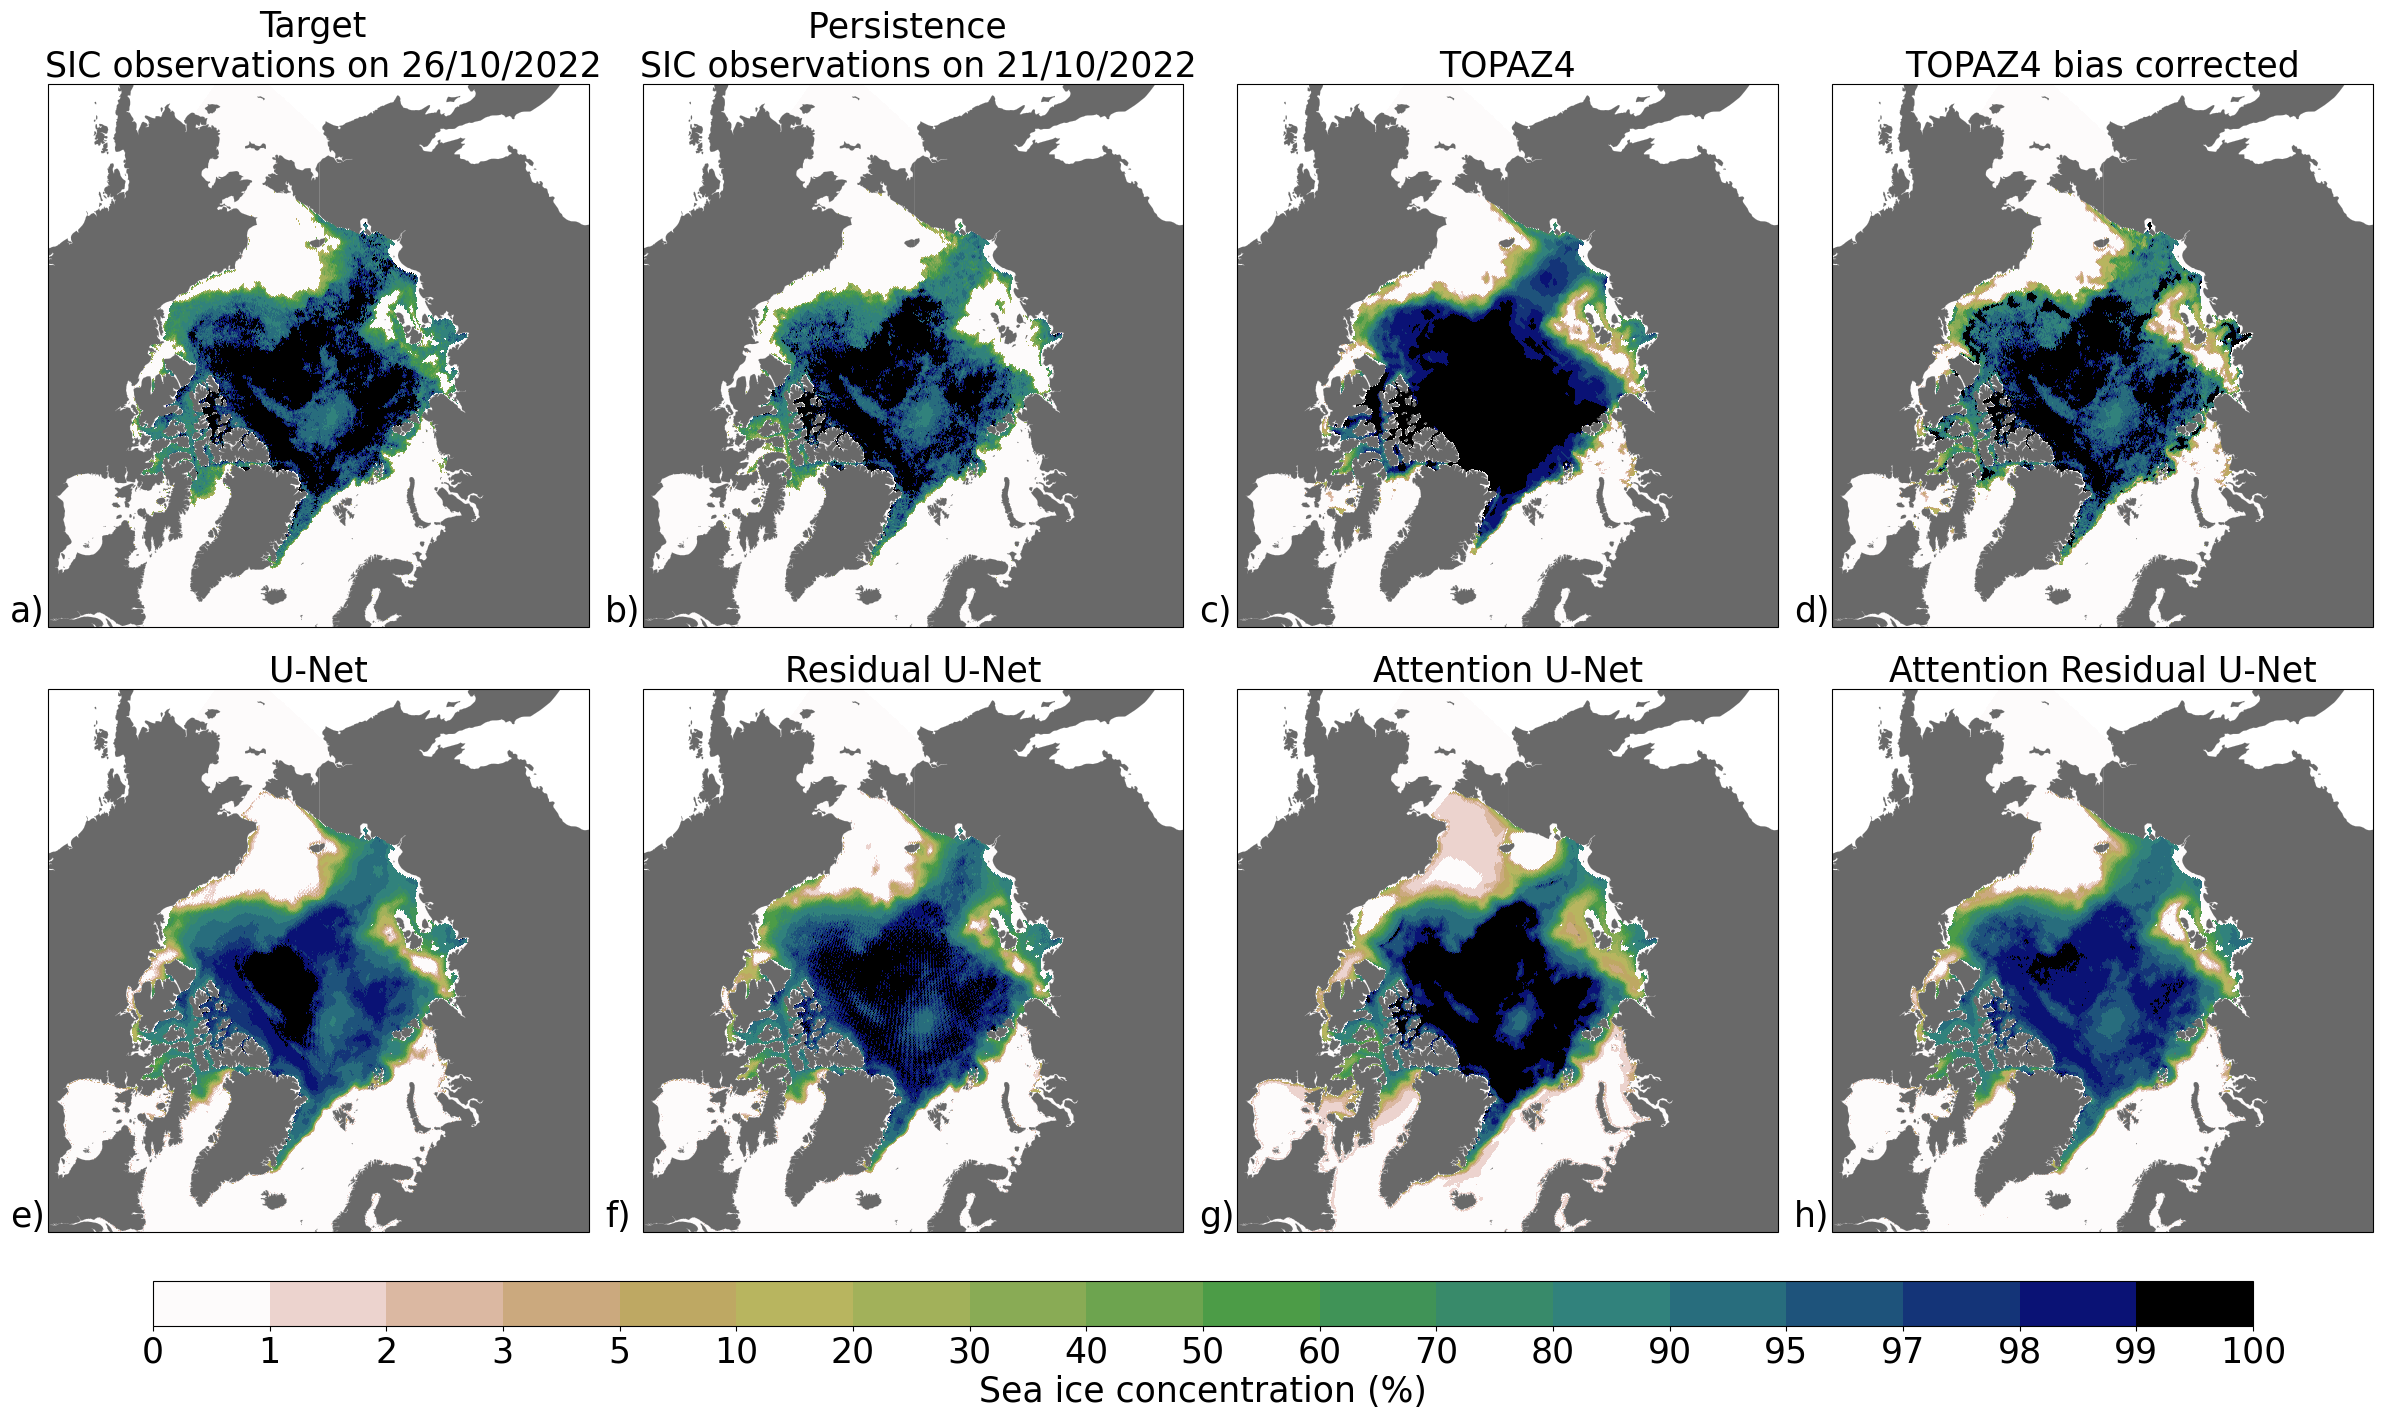

In [18]:
list_dates = make_list_dates(date_min, date_max)
forecast_start_date = list_dates[SGE_TASK_ID -1]
target_date = (datetime.datetime.strptime(forecast_start_date, "%Y%m%d") + datetime.timedelta(days = lead_time)).strftime("%Y%m%d")
#
Datasets = load_data(forecast_start_date)
make_maps(Datasets, forecast_start_date, target_date, save = True, lead_time = lead_time, p = params_maps)
tf = time.time() - t0
print(forecast_start_date, "Computing_time: ", tf)